In [1]:
## wrtiing code that goes from raw dlc to psth of the PER

##need to run this in deeplabcut environment if


#Before running this script need to have analyzed the video using deeplabcut
#deeplabcut.analyze_videos(config_path,["C:/Users/ashsm/Documents/Stanford/bruker_deeplabcut/tight_crop_vids/20230505_fly1.avi"], shuffle=1, save_as_csv=True, videotype=".avi")

import deeplabcut
import os
import h5py
import numpy as np
from matplotlib import pyplot as plt
import scipy as scipy
from scipy.signal import find_peaks
import matplotlib.image as mpimg
import DLC_functions as dlcfun


Loading DLC 2.3.0...


Still to do: save plots!

In [13]:
## variables to change

config_path = config_path = 'C:\\Users\\ashsm\\Documents\\Stanford\\bruker_deeplabcut\\bruker_crop_training\\bruker_crop-ash-2023-06-02\\config.yaml'

video_name = '20230505_fly1'

video_path = f'C:/Users/ashsm/Documents/Stanford/bruker_deeplabcut/tight_crop_vids/{video_name}.avi'


analyzed_vid_path = f"C:/Users/ashsm/Documents/Stanford/bruker_deeplabcut/bruker_crop_training/bruker_crop-ash-2023-06-02/videos/{video_name}DLC_resnet50_bruker_cropJun2shuffle1_100001.h5"

h5_savefile = f"C:/Users/ashsm/Documents/Stanford/bruker behavior/h5files_dlc/{video_name}_dlc.h5"

## optional to check individual PER (need to have ffmpeged the avi to turn it into jpg)
## NOTE: if the frames aren't from the cropped video the overlay of proboscis, head, etc won't match but the frame # should be the same
#frames_path = "C:/Users/ashsm/Documents/Stanford/bruker_deeplabcut/tight_crop_vids/20230504_fly1_test_frames"
frames_path = "E:/bruker_vid_2023/20230505/analysis/fly1"

#frames_path = None

In [4]:
## analyze video

deeplabcut.analyze_videos(config_path,[video_path], shuffle=1, save_as_csv=True, videotype=".avi")



Snapshotindex is set to 'all' in the config.yaml file. Running video analysis with all snapshots is very costly! Use the function 'evaluate_network' to choose the best the snapshot. For now, changing snapshot index to -1!
Using snapshot-100001 for model C:\Users\ashsm\Documents\Stanford\bruker_deeplabcut\bruker_crop_training\bruker_crop-ash-2023-06-02\dlc-models\iteration-0\bruker_cropJun2-trainset95shuffle1


c:\Users\ashsm\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  C:/Users/ashsm/Documents/Stanford/bruker_deeplabcut/tight_crop_vids/20230505_fly1.avi
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


'DLC_resnet50_bruker_cropJun2shuffle1_100001'

In [5]:
##getting data from dlc h5 file

#the output is essentially x,y locations for each timestamp (and likelihoods)
#could just do a check to see if likelihoods are ok and then procede with analysis
#h5py file doesn't seem to have a header...but data is stored in ['df_with_missing']['table']

#could get header from csv or just input csv.It's not too big so its ok. Could restore in h5py with better organization

#ultimately look at xy for bodypart1 and bodypart2 (possibly rename in later labeling) 
# # and get eucl distance between them (do as array slicing like foraging code)
#bodyparts	bodypart1	bodypart1	bodypart1	bodypart2	bodypart2	bodypart2	bodypart3	bodypart3	bodypart3	objectA	objectA	objectA
#coords	x	y	likelihood	x	y	likelihood	x	y	likelihood	x	y	likelihood

#changed config so the bodyparts are specified
# head	head	head	proboscis_tip	proboscis_tip	proboscis_tip	extended	extended	extended	neck	neck	neck
# x	y	likelihood	x	y	likelihood	x	y	likelihood	x	y	likelihood


# print(data[:]['values_block_0'][:,0]) ##this is the first column (head x)

path = analyzed_vid_path

head_x = dlcfun.get_data_column(path, 0)
head_y = dlcfun.get_data_column(path, 1)
head_likelihood = dlcfun.get_data_column(path, 2)
proboscis_x = dlcfun.get_data_column(path, 3)
proboscis_y = dlcfun.get_data_column(path, 4)
proboscis_likelihood = dlcfun.get_data_column(path, 5)
extend_x = dlcfun.get_data_column(path, 6)
extend_y = dlcfun.get_data_column(path, 7)
extend_likelihood = dlcfun.get_data_column(path, 8)
neck_x = dlcfun.get_data_column(path, 9)
neck_y = dlcfun.get_data_column(path, 10)
neck_likelihood = dlcfun.get_data_column(path, 11)

#save to h5 file for later retrieval
dlcfun.add_to_h5(h5_savefile, 'head_x', head_x)
dlcfun.add_to_h5(h5_savefile, 'head_y', head_y)
dlcfun.add_to_h5(h5_savefile, 'head_likelihood', head_likelihood)
dlcfun.add_to_h5(h5_savefile, 'proboscis_x', proboscis_x)
dlcfun.add_to_h5(h5_savefile, 'proboscis_y', proboscis_y)
dlcfun.add_to_h5(h5_savefile, 'proboscis_likelihood', proboscis_likelihood)
dlcfun.add_to_h5(h5_savefile, 'extend_x', extend_x)
dlcfun.add_to_h5(h5_savefile, 'extend_y', extend_y)
dlcfun.add_to_h5(h5_savefile, 'extend_likelihood', extend_likelihood)
dlcfun.add_to_h5(h5_savefile, 'neck_x', neck_x)
dlcfun.add_to_h5(h5_savefile, 'neck_y', neck_y)
dlcfun.add_to_h5(h5_savefile, 'neck_likelihood', neck_likelihood)

#calculate distance between different bodyparts
difference = np.sqrt((head_x - proboscis_x)**2 + (head_y - proboscis_y)**2)
neck_diff = np.sqrt((neck_x - proboscis_x)**2 + (neck_y - proboscis_y)**2)
ext_diff = np.sqrt((extend_x - proboscis_x)**2 + (extend_y - proboscis_y)**2)
dlcfun.add_to_h5(h5_savefile, 'difference', difference)
dlcfun.add_to_h5(h5_savefile, 'neck difference', neck_diff)
dlcfun.add_to_h5(h5_savefile, 'extension difference', ext_diff)



In [54]:


#scipy parameters
prominence = 12  ## roughly the extension amount from baseline
width = 10  ## how far away from other PER
height =  40  ## the absolute value from baseline and not that useful, could remove
distance = 10 ##not used for filtered

#calculate dlc peaks
DLC_peaks, properties = scipy.signal.find_peaks(difference, height = height, prominence = prominence, distance = distance, width = width)
dlcfun.add_to_h5(h5_savefile, 'DLC peaks unfiltered', DLC_peaks)

## filter dlc peaks using a median filter and removing peaks that are more than 1 std from median
## make median filter of median_difference_PER (difference to median head position)
median_head_x = np.median(head_x)
median_head_y = np.median(head_y)
median_difference_PER = np.sqrt((proboscis_x - np.ones(len(proboscis_x))*median_head_x)**2 + (proboscis_y - np.ones(len(proboscis_y))*median_head_y)**2)
print('median', median_difference_PER)

filtered_median_difference_PER = scipy.signal.medfilt(median_difference_PER, 5)
filtered_DLC_peaks, filtered_properties = scipy.signal.find_peaks(filtered_median_difference_PER, width = width, prominence = prominence, height = height)
print(len(filtered_DLC_peaks))

#remove PER that are more than 1 std from median height 
print(np.std(filtered_median_difference_PER))
filter_range = np.mean(filtered_median_difference_PER) + 1*np.std(filtered_median_difference_PER)
print(filter_range)


double_filtered_DLC_peaks = [peak for peak in filtered_DLC_peaks if filtered_median_difference_PER[peak] > filter_range]
print('double', len(double_filtered_DLC_peaks))

dlcfun.add_to_h5(h5_savefile, 'median filtered DLC peaks', filtered_DLC_peaks)
dlcfun.add_to_h5(h5_savefile, 'median and std filtered DLC peaks', double_filtered_DLC_peaks)

median [48.54717389 48.80922682 49.08472012 ... 34.89592159 34.88931352
 62.23194532]
331
11.858604777078533
53.039021891214816
double 287


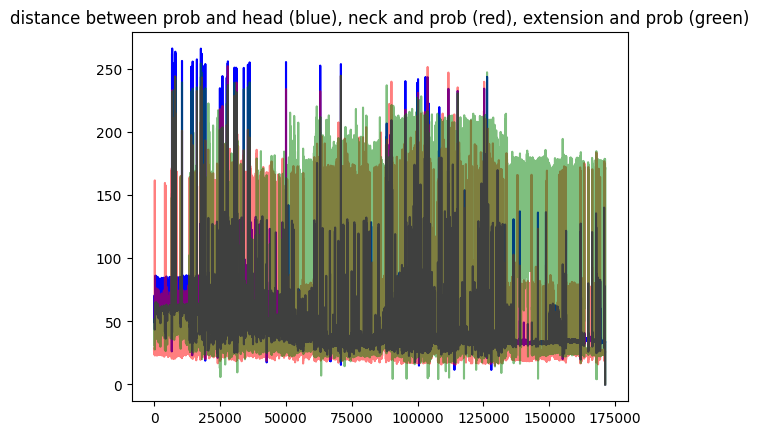

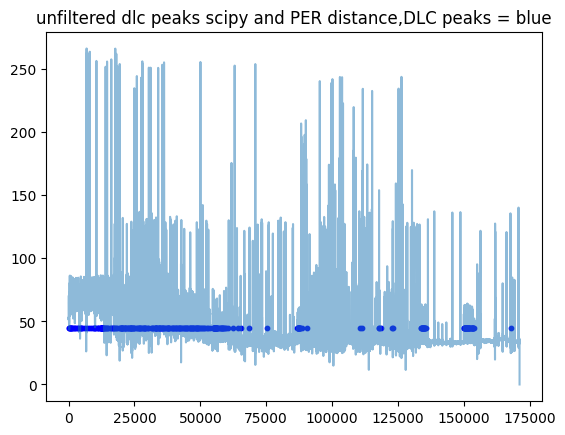

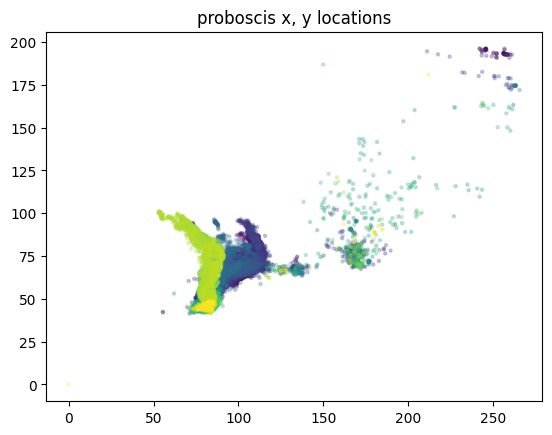

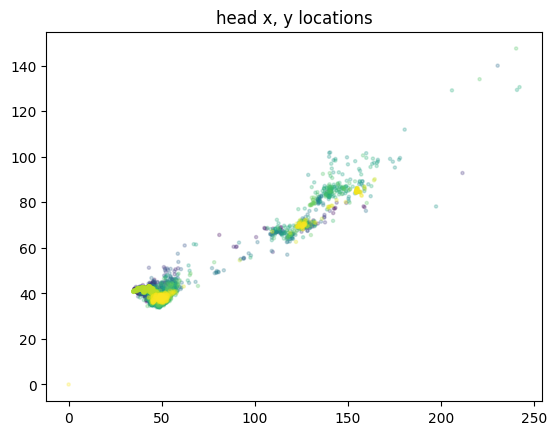

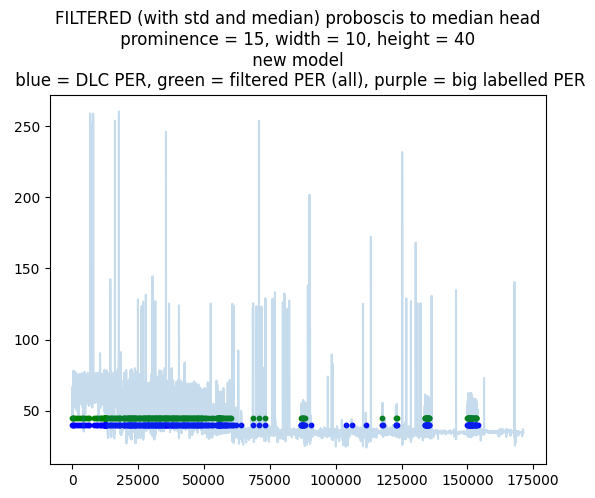

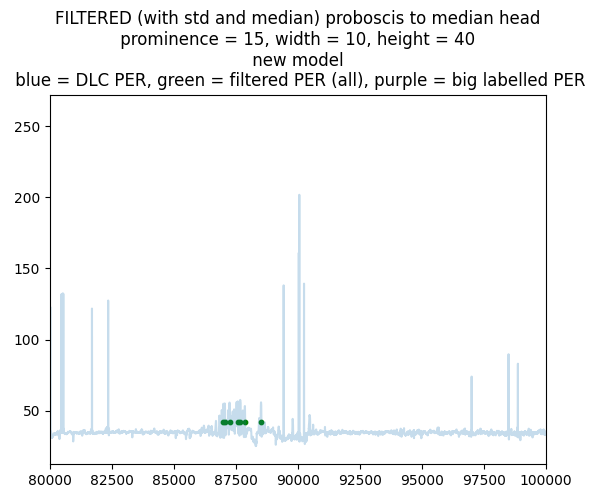

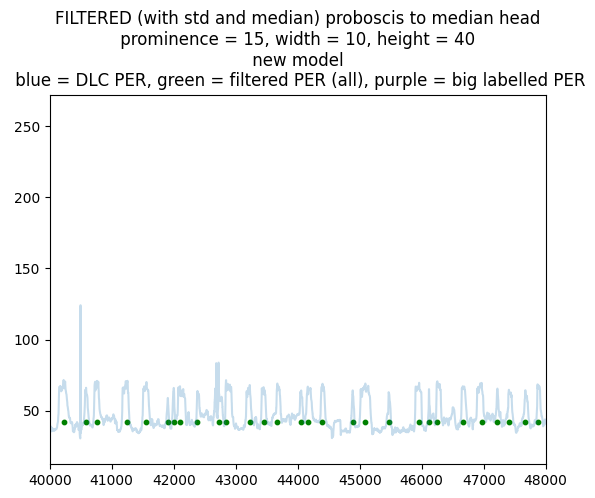

In [51]:
## plots

#plot distance between body parts
plt.plot(difference, color = 'blue')
plt.plot(neck_diff, alpha = .5, color = 'red')
plt.plot(ext_diff, alpha = .5, color ='green')
plt.title('distance between prob and head (blue), neck and prob (red), extension and prob (green)')
plt.show()


#plot unfiltered scipy per peaks and distance between head and per
plt.plot(difference, alpha = .5)
plt.scatter(DLC_peaks, np.ones(len(DLC_peaks))*45, color = 'blue', s = 10)
plt.title('unfiltered dlc peaks scipy and PER distance,DLC peaks = blue')
plt.show()

#plot the variation in proboscis tip and head location
plt.scatter(proboscis_x, proboscis_y, c = range(len(proboscis_x)), alpha = .25, s = 5)
plt.title('proboscis x, y locations')
plt.show()

plt.scatter(head_x, head_y, c = range(len(proboscis_x)), alpha = .25, s = 5)
plt.title('head x, y locations')
plt.show()



# plot filtered dlc
plt.plot(filtered_median_difference_PER, alpha = .25)
plt.scatter(filtered_DLC_peaks, np.ones(len(filtered_DLC_peaks))*40, color = 'blue', s = 10)
plt.scatter(double_filtered_DLC_peaks, np.ones(len(double_filtered_DLC_peaks))*45, color = 'green', s = 10)
#plt.scatter(frame_num_per, np.ones(len(frame_num_per))*41, color = 'green', s = 10, alpha = 1)
#plt.scatter(frame_num_big_per, np.ones(len(frame_num_big_per))*42, color = 'purple', s = 10, alpha = 1)
plt.title(f'FILTERED (with std and median) proboscis to median head\n prominence = {prominence}, width = {width}, height = {height} \n new model \n blue = DLC PER, green = filtered PER (all), purple = big labelled PER')
#plt.xlim(1000,3000)
plt.show()


plt.plot(filtered_median_difference_PER, alpha = .25)
#plt.scatter(filtered_DLC_peaks, np.ones(len(filtered_DLC_peaks))*40, color = 'blue', s = 10)
plt.scatter(double_filtered_DLC_peaks, np.ones(len(double_filtered_DLC_peaks))*42, color = 'green', s = 10)
#plt.scatter(frame_num_per, np.ones(len(frame_num_per))*41, color = 'green', s = 10, alpha = 1)
#plt.scatter(frame_num_big_per, np.ones(len(frame_num_big_per))*42, color = 'purple', s = 10, alpha = 1)
plt.title(f'FILTERED (with std and median) proboscis to median head\n prominence = {prominence}, width = {width}, height = {height} \n new model \n blue = DLC PER, green = filtered PER (all), purple = big labelled PER')
plt.xlim(80000,100000)
plt.show()

plt.plot(filtered_median_difference_PER, alpha = .25)
#plt.scatter(filtered_DLC_peaks, np.ones(len(filtered_DLC_peaks))*40, color = 'blue', s = 10)
plt.scatter(double_filtered_DLC_peaks, np.ones(len(double_filtered_DLC_peaks))*42, color = 'green', s = 10)
#plt.scatter(frame_num_per, np.ones(len(frame_num_per))*41, color = 'green', s = 10, alpha = 1)
#plt.scatter(frame_num_big_per, np.ones(len(frame_num_big_per))*42, color = 'purple', s = 10, alpha = 1)
plt.title(f'FILTERED (with std and median) proboscis to median head\n prominence = {prominence}, width = {width}, height = {height} \n new model \n blue = DLC PER, green = filtered PER (all), purple = big labelled PER')
plt.xlim(40000,48000)
plt.show()


In [56]:
print(double_filtered_DLC_peaks)

[74, 272, 351, 434, 686, 775, 946, 1166, 1463, 2140, 2481, 2589, 2789, 3635, 4102, 4184, 4625, 5205, 5840, 6494, 8243, 8901, 9533, 10148, 11082, 11085, 11660, 12052, 12098, 12131, 12196, 12200, 12302, 12359, 12403, 12443, 12477, 12518, 12563, 12619, 12658, 12701, 12730, 12803, 12865, 12905, 13014, 13767, 13930, 14505, 14739, 15059, 15532, 16138, 16401, 16918, 17282, 17301, 17593, 17952, 18134, 18540, 19380, 19640, 19780, 20126, 20313, 20411, 20441, 20654, 21042, 21232, 21365, 21524, 21780, 22005, 22184, 22202, 22456, 22485, 22824, 23101, 23170, 23398, 23559, 23647, 23744, 23763, 24319, 24648, 24850, 25410, 25560, 25787, 26193, 26575, 26724, 27001, 27029, 27299, 27520, 27632, 27716, 27951, 28180, 28398, 28602, 28791, 28872, 29049, 29259, 29546, 29810, 30092, 30259, 30450, 30890, 31205, 31291, 31522, 31720, 31933, 32148, 32467, 32696, 32923, 33032, 33136, 33338, 33533, 33800, 34156, 34314, 34342, 34733, 34868, 35086, 35314, 35488, 35652, 35888, 36051, 36257, 36589, 36846, 37319, 37536, 3

287
E:/bruker_vid_2023/20230505/analysis/fly1


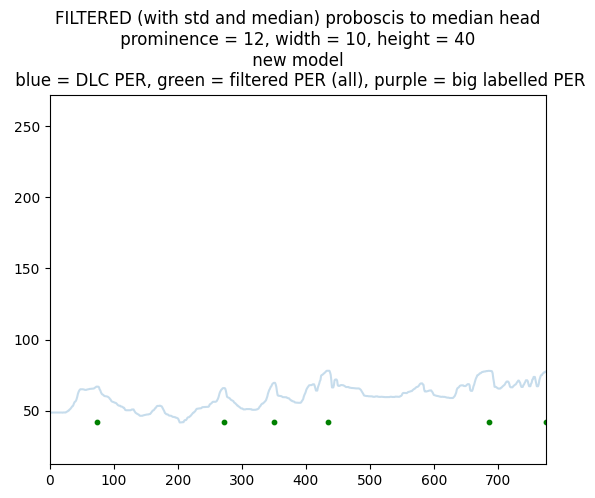

found path!
74


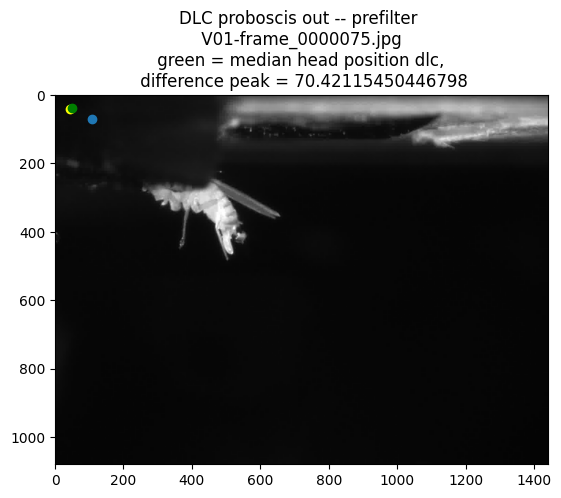

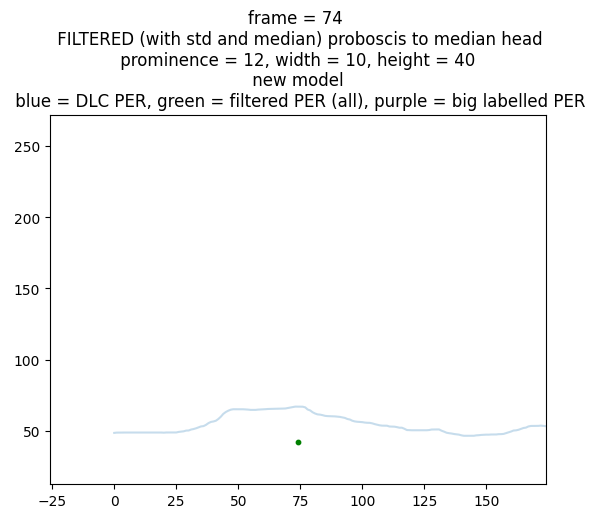

272


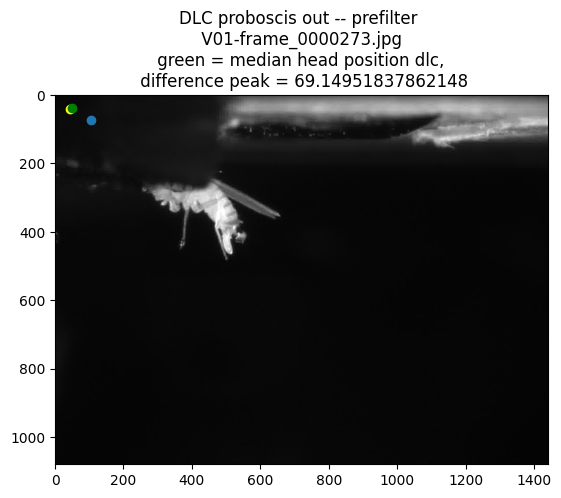

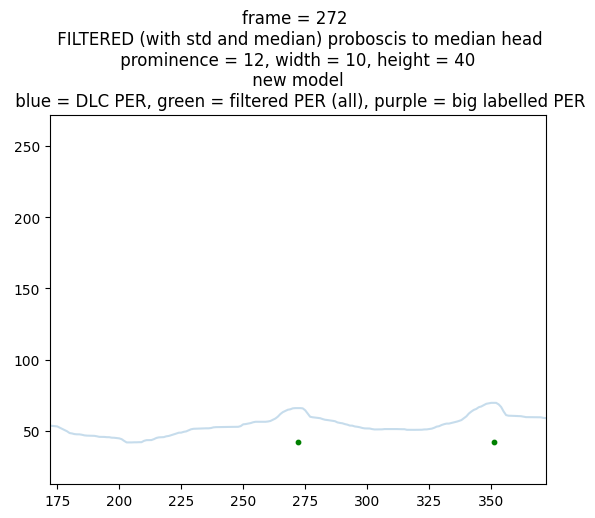

351


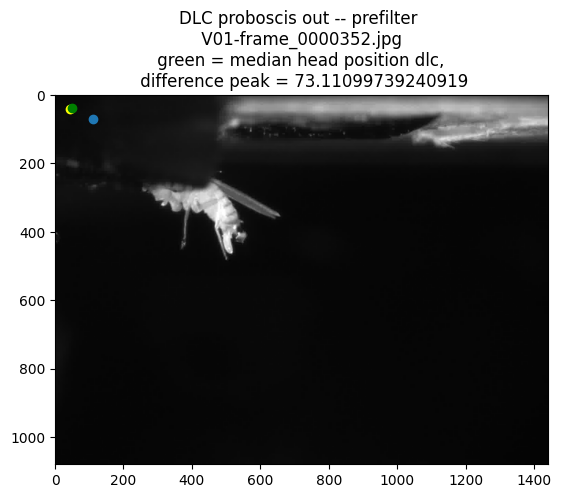

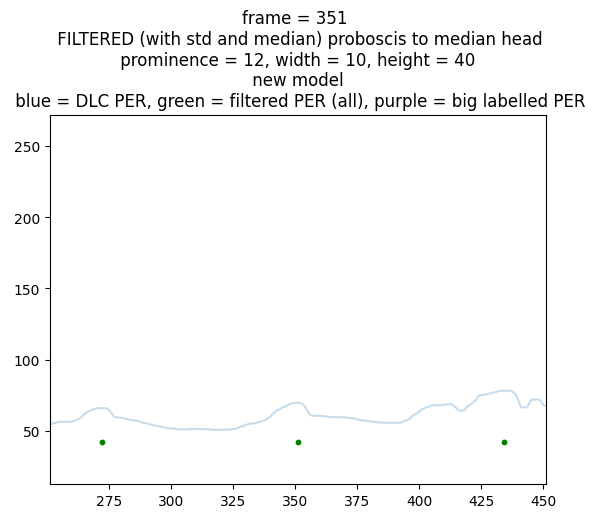

434


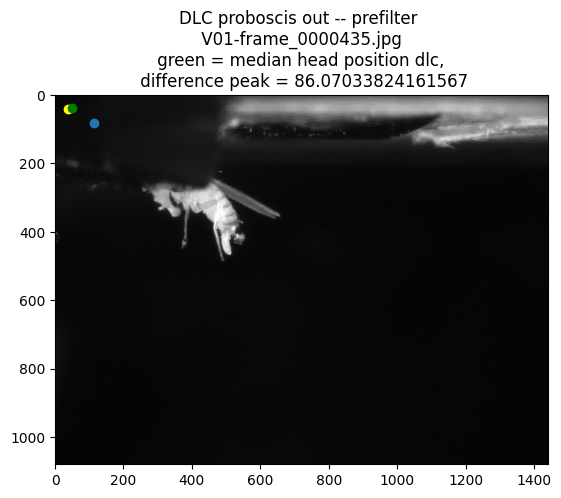

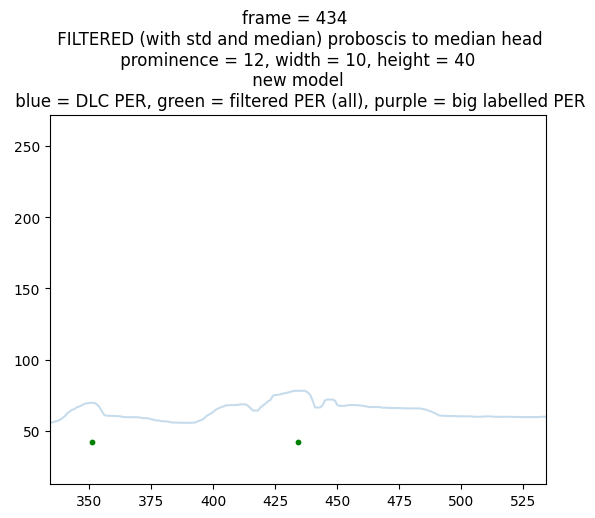

686


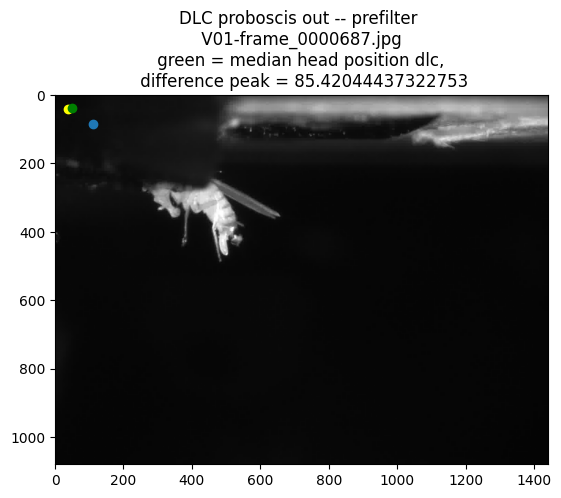

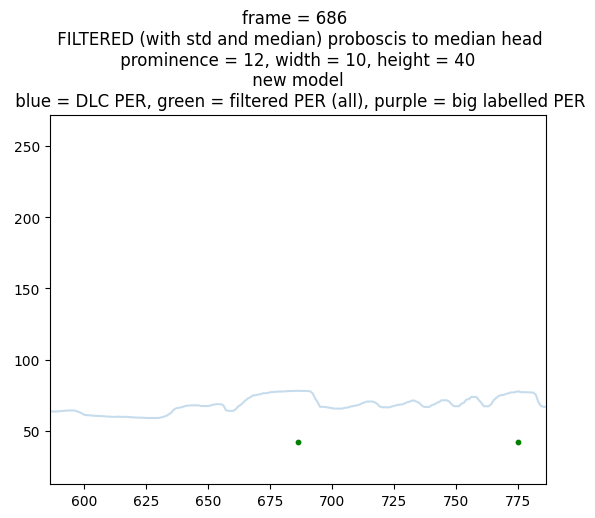

In [58]:
show_scatter = True  #change to False if don't want individual scatter plots for each frame


#check individual frames for PER (if the video has been frame jpeged)
median_head_x = np.median(head_x)
median_head_y = np.median(head_y)

#peaks_to_look_at = DLC_peaks #could change to double_filtered_DLC_peaks 
peaks_to_look_at = double_filtered_DLC_peaks 
print(len(double_filtered_DLC_peaks))

max_frames = 5 #max number of frames to look at 
print(frames_path)

plt.plot(filtered_median_difference_PER, alpha = .25)
plt.scatter(double_filtered_DLC_peaks, np.ones(len(double_filtered_DLC_peaks))*42, color = 'green', s = 10)
plt.title(f'FILTERED (with std and median) proboscis to median head\n prominence = {prominence}, width = {width}, height = {height} \n new model \n blue = DLC PER, green = filtered PER (all), purple = big labelled PER')
plt.xlim(0,peaks_to_look_at[max_frames])
plt.show()

if frames_path is not None:
    all_frames = os.listdir(frames_path) 
    print(f'found path!')
    for frame_number in peaks_to_look_at[0:max_frames]:
        print(frame_number)
        frame = mpimg.imread(os.path.join(frames_path, all_frames[frame_number]))
        plt.scatter(proboscis_x[frame_number], proboscis_y[frame_number])
        plt.scatter(head_x[frame_number], head_y[frame_number], color = 'yellow')
        plt.scatter(median_head_x, median_head_y, color = 'green')
        plt.imshow(frame)
        plt.title(f'DLC proboscis out -- prefilter \n {all_frames[frame_number]} \n green = median head position dlc, \n difference peak = {difference[frame_number]}')
        plt.show()

        if show_scatter:
            plt.plot(filtered_median_difference_PER, alpha = .25)
            plt.scatter(double_filtered_DLC_peaks, np.ones(len(double_filtered_DLC_peaks))*42, color = 'green', s = 10)
            plt.title(f'frame = {frame_number} \n FILTERED (with std and median) proboscis to median head\n prominence = {prominence}, width = {width}, height = {height} \n new model \n blue = DLC PER, green = filtered PER (all), purple = big labelled PER')
            plt.xlim(frame_number - 100,frame_number + 100)
            plt.show()

In [ ]:
## make psth for double filtered peaks
## NEED FRAMERATE and light times
#(use dlc_PSTH.ipynb code)

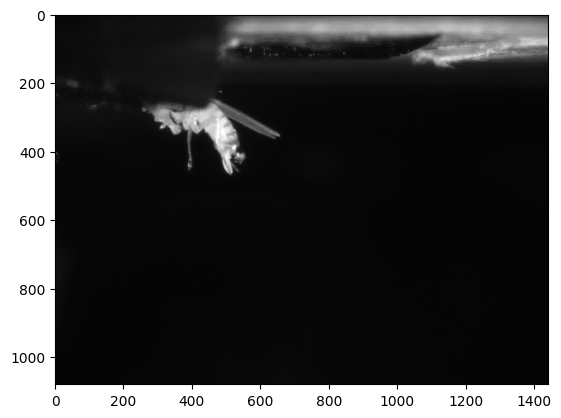

In [40]:
frame_number = 2700
frame = mpimg.imread(os.path.join(frames_path, all_frames[frame_number]))
plt.imshow(frame)
##missed this one. 

found path!


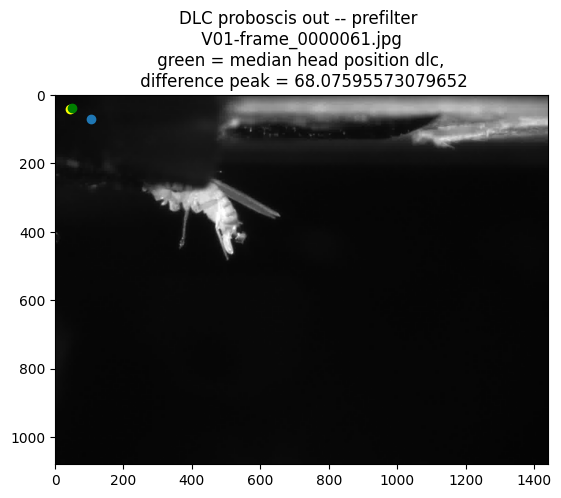

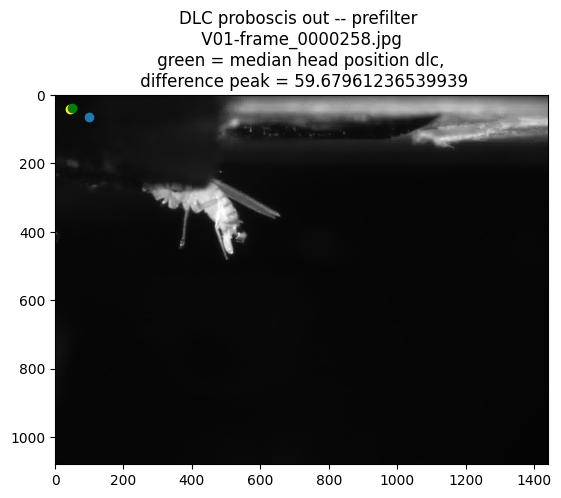

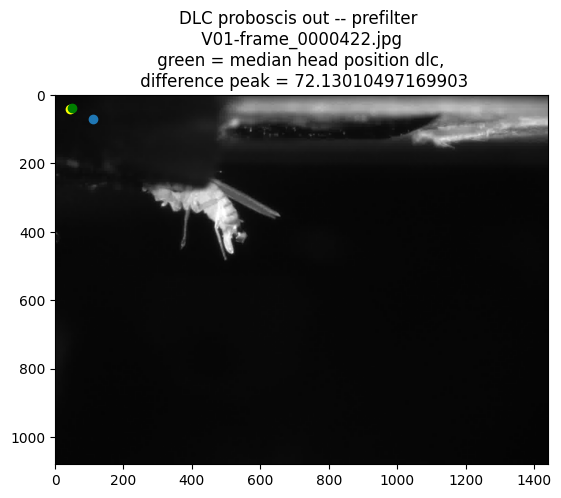

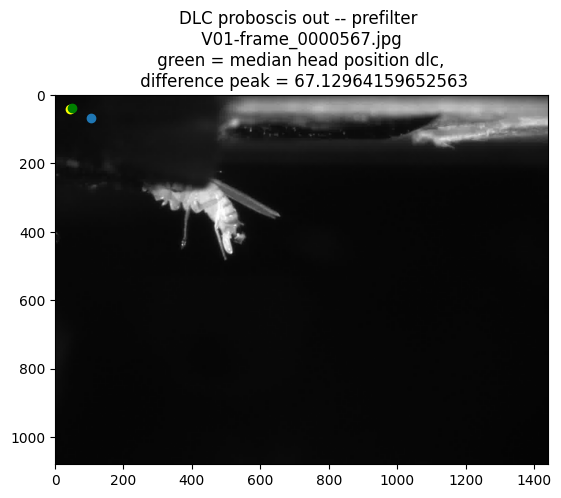

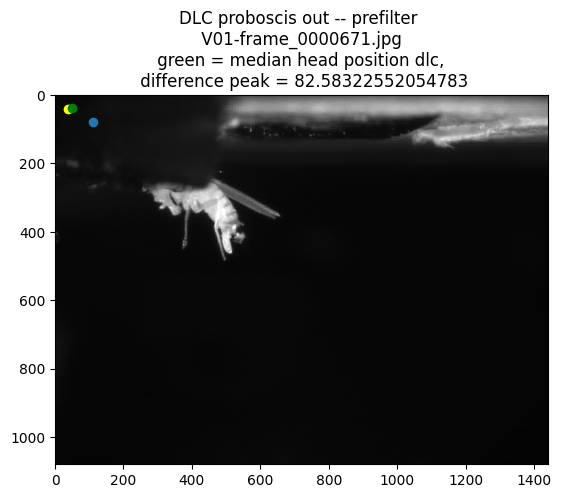

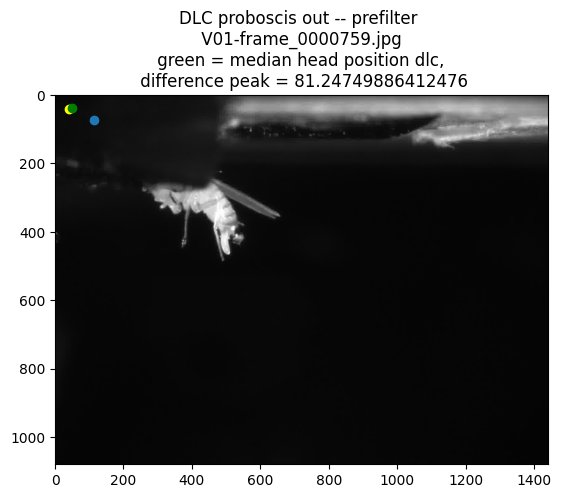

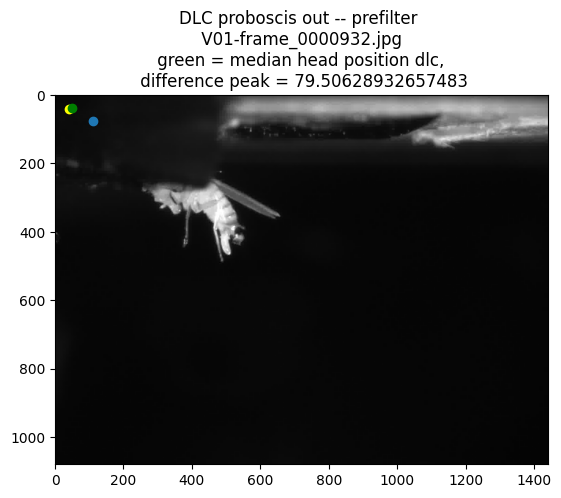

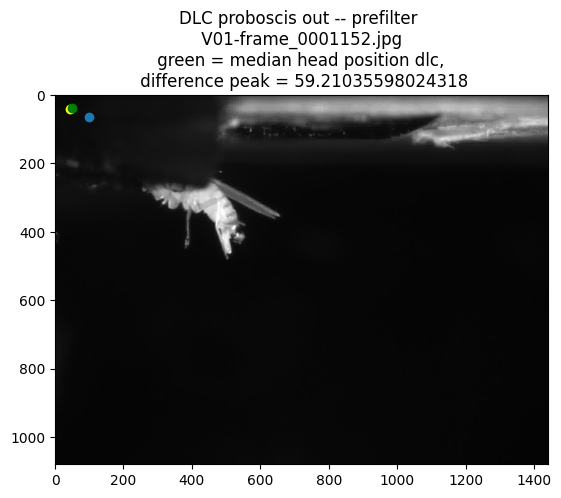

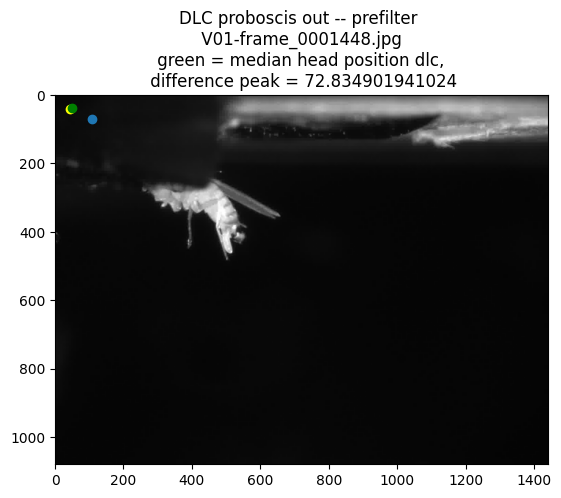

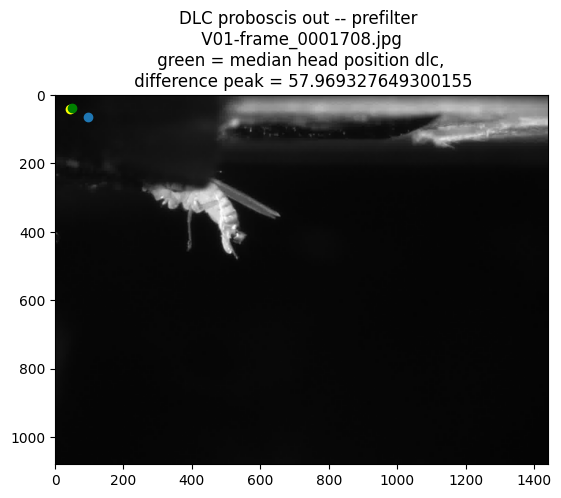

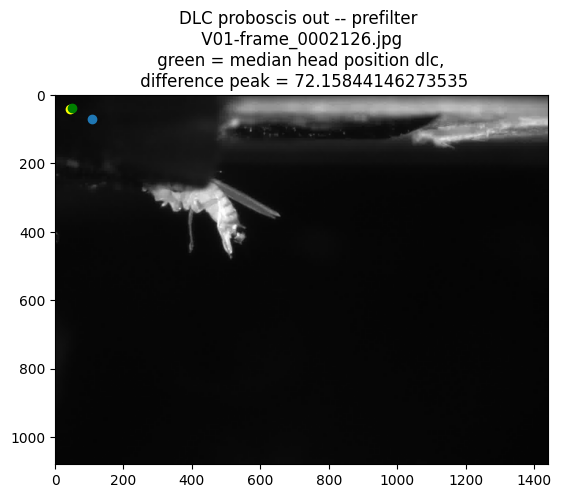

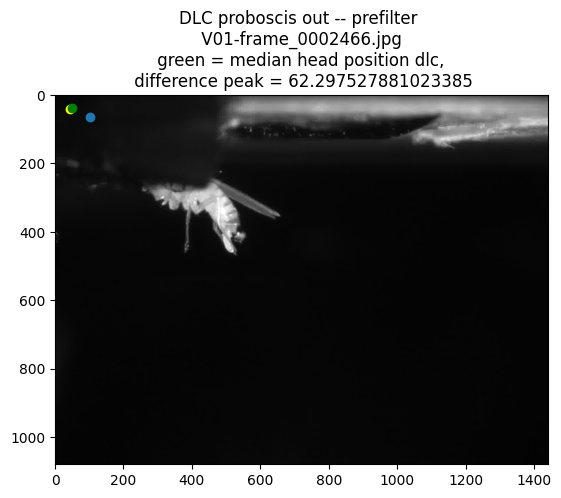

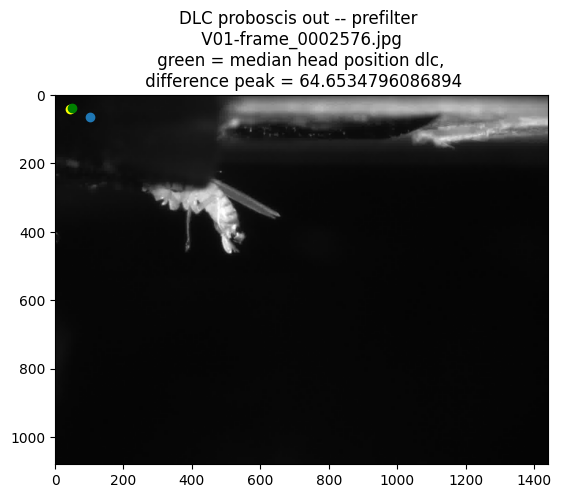

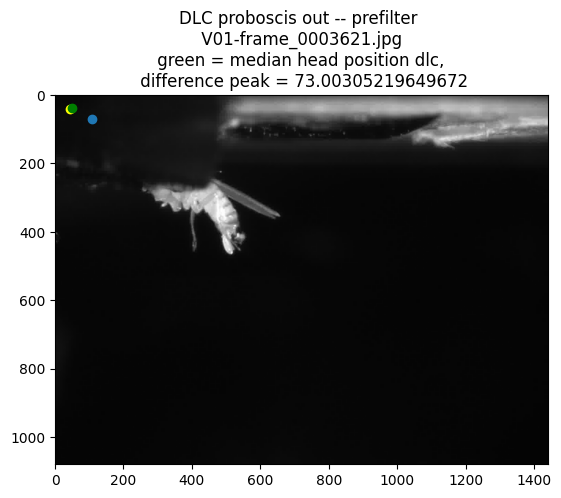

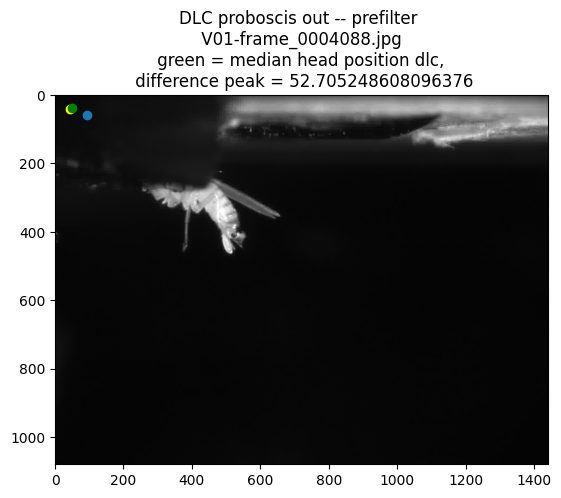

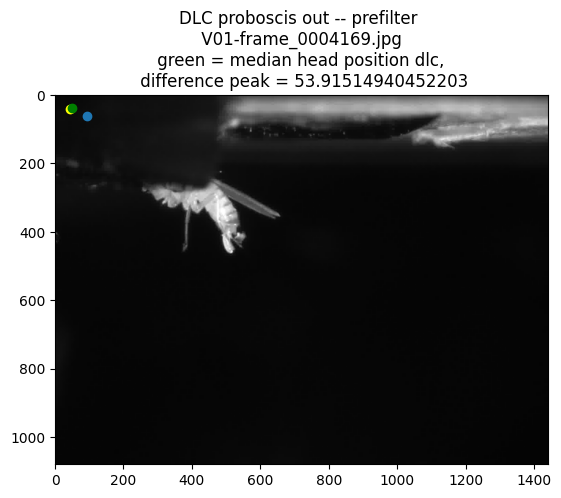

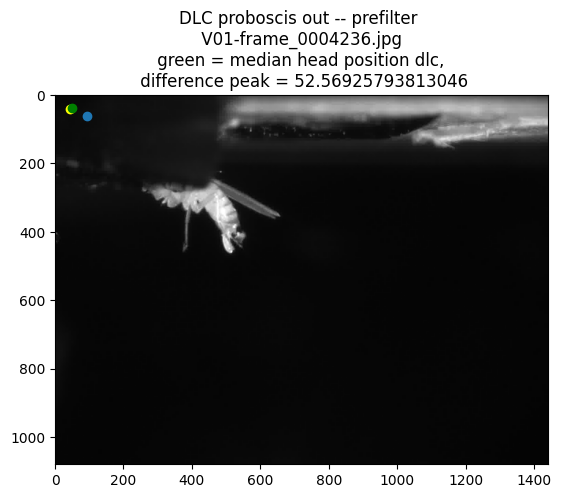

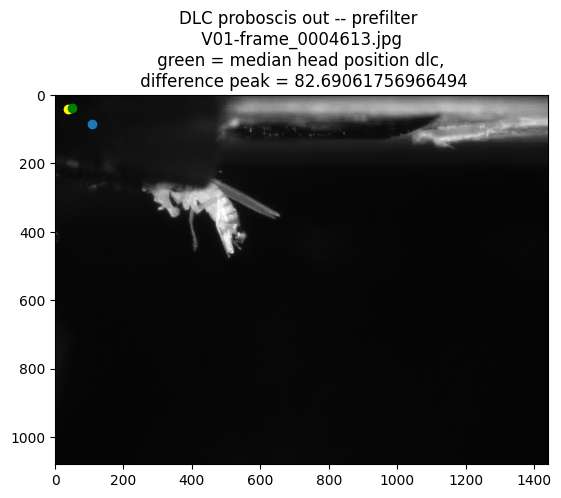

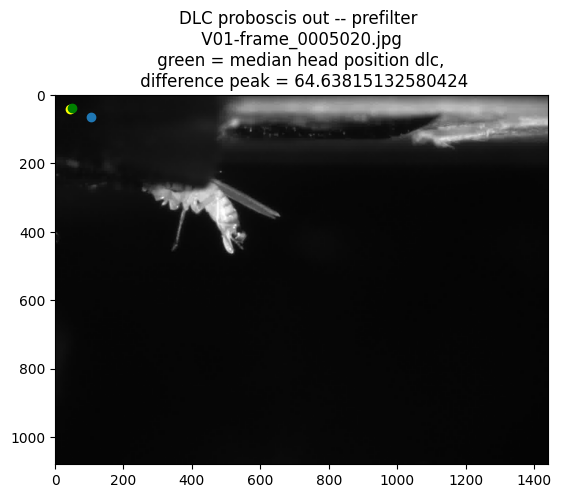

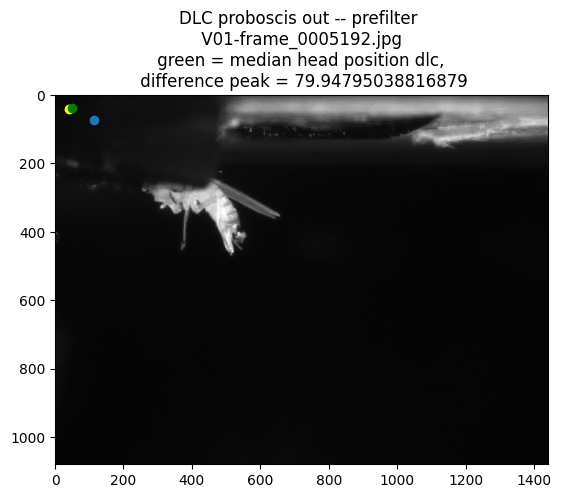

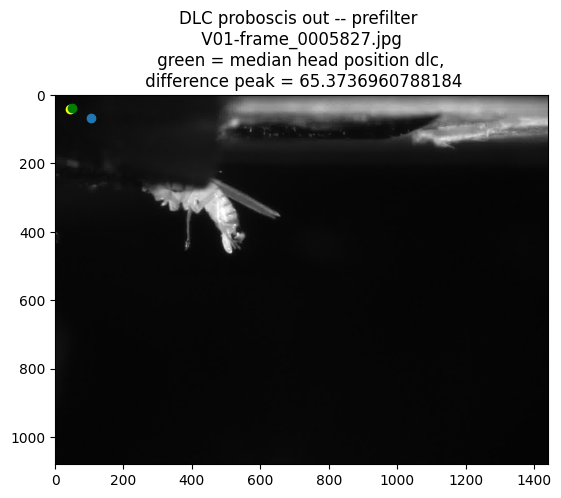

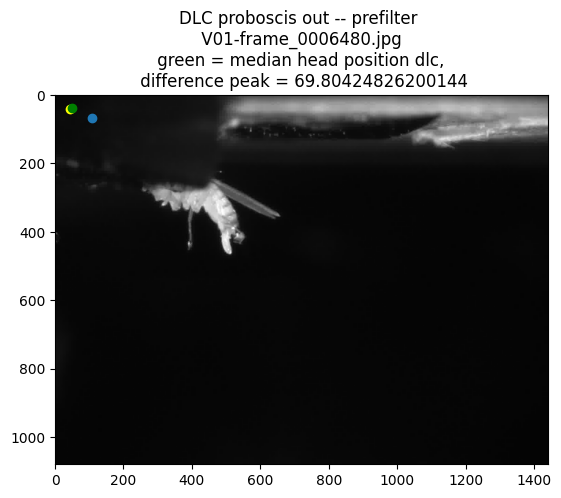

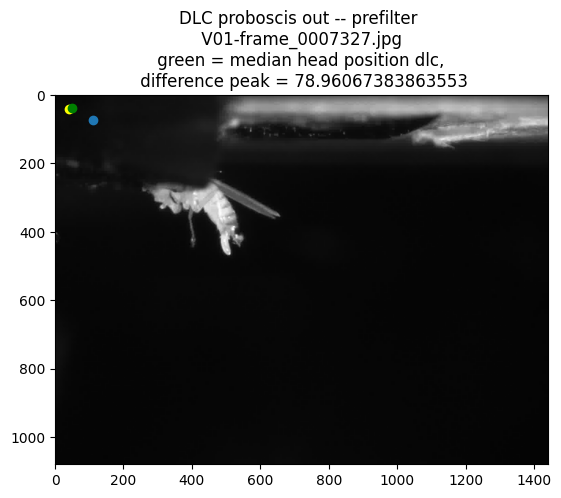

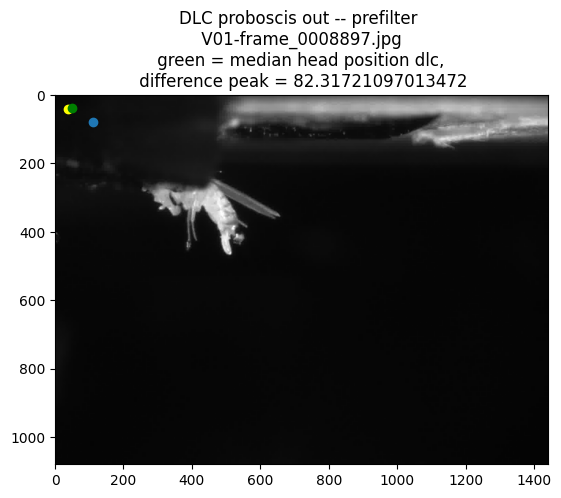

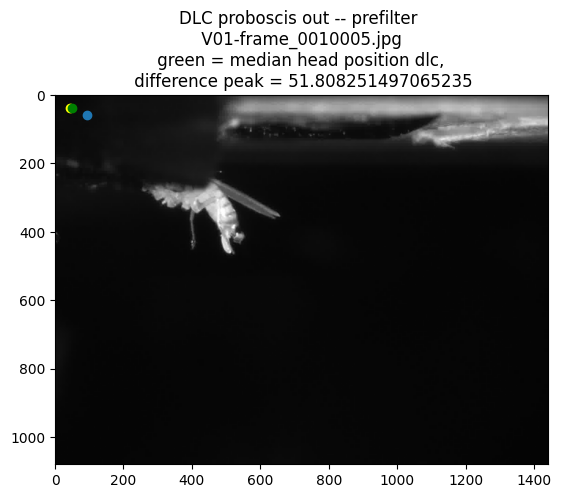

In [30]:
## frames 5 before the PER frame
buffer = 15

if frames_path is not None:
    all_frames = os.listdir(frames_path) 
    print(f'found path!')
    for per_frame_number in DLC_peaks[0:max_frames]:
        frame_number = per_frame_number - buffer
        if frame_number in DLC_peaks:
            print(f"this frame {frame_number} is also in DLC peaks")
        frame = mpimg.imread(os.path.join(frames_path, all_frames[frame_number]))
        plt.scatter(proboscis_x[frame_number], proboscis_y[frame_number])
        plt.scatter(head_x[frame_number], head_y[frame_number], color = 'yellow')
        plt.scatter(median_head_x, median_head_y, color = 'green')
        plt.imshow(frame)
        plt.title(f'DLC proboscis out -- prefilter \n {all_frames[frame_number]} \n green = median head position dlc, \n difference peak = {difference[frame_number]}')
        plt.show()